# POS Tagging Using Viterbi Algorithm



##### In this Assignment we apply techniques to improve the Vanilla Viterbi algorithm. 
##### Following are the steps involved:
##### 1. Simple Vanilla Viterbi algorithm is developed.
##### 2. Viterbi Modification 1 - Probability based algorithm
##### 3. Viterbi Modification 2 - Rule Based Algorithm.
##### 4. Test data is tested on both the Viterbi modification 
##### 5. The modified Viterbi algorithms are first tested on sampled test data for comparison.
##### 6. The final algorithm and vanilla Viterbi Algorithm are the tested on full testing data for comparison.



In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, pprint
import time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import os

# Data Preparation

In [2]:
wsj = list(nltk.corpus.treebank.tagged_sents(tagset = 'universal'))

In [3]:
print(wsj[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [29]:
# Splitting into train and test
random.seed(1234)
train_set,test_set = train_test_split(wsj,train_size=0.95,test_size=0.05,random_state = 101)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('Reliance', 'NOUN'), ('confirmed', 'VERB'), ('the', 'DET'), ('filing', 'NOUN'), ('but', 'CONJ'), ('would', 'VERB'), ("n't", 'ADV'), ('elaborate', 'VERB'), ('.', '.')], [('*', 'X'), ('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.')], [('Because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('rulings', 'NOUN'), (',', '.'), ('the', 'DET'), ('Commerce', 'NOUN'), ('Department', 'NOUN'), ('will', 'VERB'), ('continue', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('investigate', 'VERB'), ('complaints', 'NOUN'), ('*ICH*-2', 'X'), ('by', 'ADP'), ('U.S.', 'NOUN'), ('sweater', 'NOUN'), ('makers', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('imports', 'NOUN'), ('are', 'VERB'), ('reaching', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('at', 'ADP'), ('unfairly', 'ADV'), ('low', 'ADJ'), ('prices', 'NOUN'), ('in', 'ADP'), ('violation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('anti-dumping', 'ADJ'), ('act', 'NOUN'), ('.', '.')], [('What', 'PRON'), ('she',

In [30]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95547

In [31]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*']

In [32]:
# vocabulary
V = set(tokens)
print(len(V))

12100


In [33]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [34]:
print(T)

{'CONJ', 'DET', 'ADV', 'NUM', 'X', 'PRON', 'ADP', 'ADJ', 'PRT', 'VERB', 'NOUN', '.'}


## 2. POS Tagging Algorithm - HMM

#### We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

#### In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


#### P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

#### P(w/t) = count(w, t) / count(t). 


#### The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


#### Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

## Emission Probabilities

In [35]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [36]:
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

# Transition Probability

In [37]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [38]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [39]:
# Converting this into dataframe
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [40]:
tags_df

,CONJ,DET,ADV,NUM,X,PRON,ADP,ADJ,PRT,VERB,NOUN,.
CONJ,0.000465,0.121339,0.055323,0.039981,0.008833,0.058113,0.052534,0.118085,0.004649,0.156671,0.349140,0.034868
DET,0.000483,0.005676,0.012438,0.022220,0.045405,0.003744,0.009540,0.204323,0.000242,0.039850,0.638087,0.017993
ADV,0.006956,0.069891,0.080490,0.030474,0.023186,0.014906,0.118582,0.129182,0.014243,0.343491,0.031467,0.137131
NUM,0.013699,0.003276,0.002978,0.184932,0.210542,0.001489,0.036033,0.034247,0.026504,0.018761,0.350208,0.117332
X,0.010662,0.054742,0.024984,0.002864,0.076384,0.055538,0.142584,0.017187,0.185232,0.203851,0.062381,0.163590
PRON,0.005360,0.009954,0.034074,0.006508,0.089969,0.007657,0.022971,0.073124,0.013017,0.485452,0.210949,0.040965
ADP,0.000962,0.324709,0.014006,0.062226,0.034427,0.070031,0.016893,0.107024,0.001390,0.008340,0.320967,0.039025
ADJ,0.016971,0.004943,0.004778,0.021256,0.021091,0.000330,0.078267,0.066403,0.010710,0.011699,0.699621,0.063931
PRT,0.002306,0.097858,0.010214,0.056672,0.013509,0.017792,0.020099,0.083031,0.001647,0.405272,0.247776,0.043822
VERB,0.005577,0.134392,0.081952,0.022851,0.217506,0.035786,0.092022,0.064988,0.030674,0.169249,0.110070,0.034934


In [41]:
tags_df.loc['.', :]

CONJ    0.057538
DET     0.173335
ADV     0.052324
NUM     0.081003
X       0.026971
PRON    0.066349
ADP     0.091342
ADJ     0.043963
PRT     0.002427
VERB    0.089095
NOUN    0.222242
.       0.093320
Name: ., dtype: float32

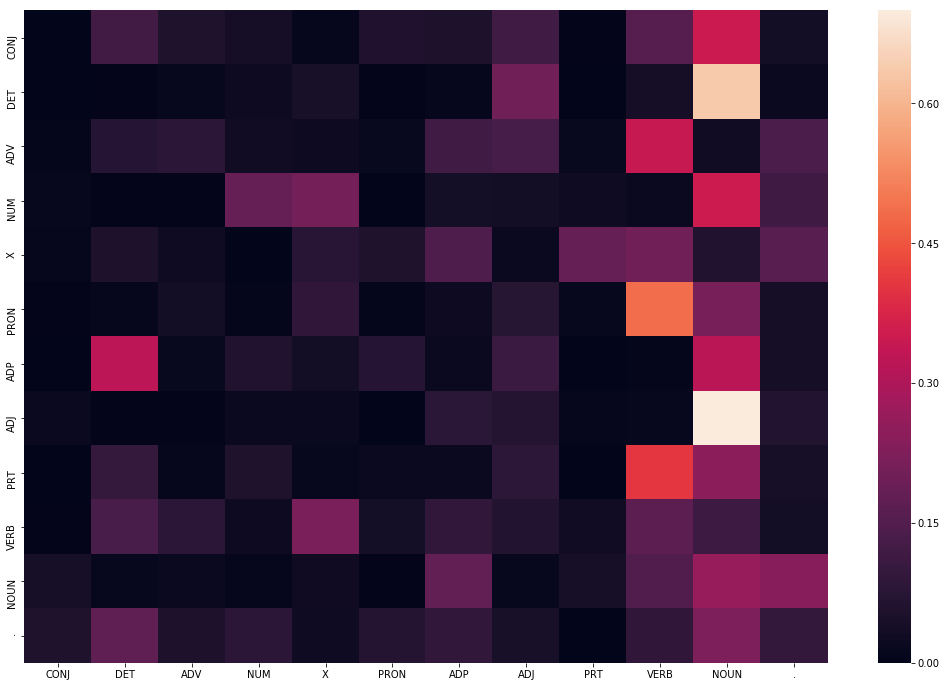

In [42]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

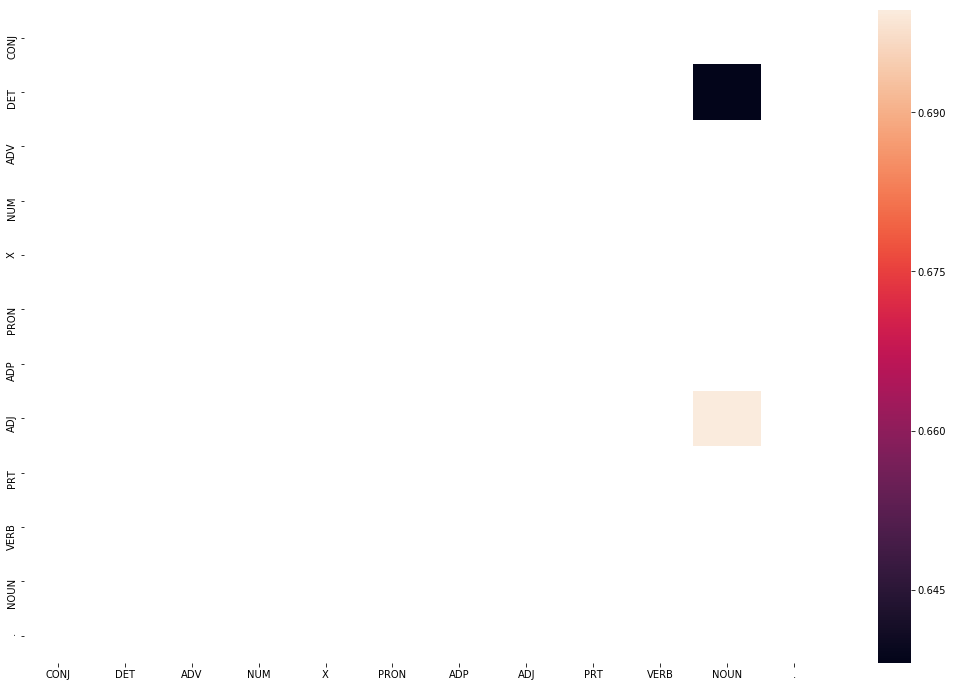

In [43]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Viterbi Algorithm

#### Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

#### We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

#### Note: P(tag|start) = P(tag|'.') 

In [44]:
len(train_tagged_words)

95547

In [45]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

## 4. Evaluating on Test Set

In [46]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('Contra', 'NOUN'),
  ('military', 'ADJ'),
  ('command', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('statement', 'NOUN'),
  ('from', 'ADP'),
  ('Honduras', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Sandinista', 'NOUN'),
  ('troops', 'NOUN'),
  ('had', 'VERB'),
  ('launched', 'VERB'),
  ('a', 'DET'),
  ('major', 'ADJ'),
  ('offensive', 'NOUN'),
  ('against', 'ADP'),
  ('the', 'DET'),
  ('rebel', 'NOUN'),
  ('forces', 'NOUN'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Bucking', 'VERB'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('trend', 'NOUN'),
  (',', '.'),
  ('an', 'DET'),
  ('issue', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('from', 'ADP'),
  ('Detroit', 'NOUN'),
  (',', '.'),
  ('Mich.', 'NOUN'),
  (',', '.'),
  ('apparently', 'ADV'),
  ('drew'

In [47]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  27.865619659423828
[('The', 'DET'), ('Contra', 'CONJ'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'CONJ'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'CONJ'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'CONJ'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'CONJ'), ('forces', 'NOUN'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'CONJ'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'CONJ'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('intere

In [48]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

accuracy = len(check)/len(tagged_seq)

accuracy

0.8938053097345132

In [49]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('Contra', 'CONJ'), ('Contra', 'NOUN')),
 (('command', 'VERB'), ('command', 'NOUN')),
 (('Honduras', 'CONJ'), ('Honduras', 'NOUN')),
 (('Sandinista', 'CONJ'), ('Sandinista', 'NOUN')),
 (('offensive', 'CONJ'), ('offensive', 'NOUN')),
 (('rebel', 'CONJ'), ('rebel', 'NOUN')),
 (('Bucking', 'CONJ'), ('Bucking', 'VERB')),
 (('drew', 'CONJ'), ('drew', 'VERB')),
 (('Eveready', 'CONJ'), ('Eveready', 'NOUN')),
 (('*T*-252', 'CONJ'), ('*T*-252', 'X')),
 (('complaining', 'CONJ'), ('complaining', 'VERB')),
 (('up', 'ADV'), ('up', 'PRT'))]

## Viterbi Modification - 1


### Probability Based Algorithm

In [50]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [51]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',accuracy*100)

Time taken in seconds:  26.046510219573975
Modified Viterbi_1 Accuracy:  94.69026548672566


#### Adding Tag occurance probability weights: we will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

###### This scheme will also take into account that some POS tags are more likely to occur as compared to others.

In [53]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in T:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('CONJ', 0.02251248076862696),
 ('DET', 0.08666938784053921),
 ('ADV', 0.031597015081582885),
 ('NUM', 0.035145007169246546),
 ('X', 0.06576867928872701),
 ('PRON', 0.0273373313657153),
 ('ADP', 0.0978889970381069),
 ('ADJ', 0.06351847781719991),
 ('PRT', 0.03176447193527793),
 ('VERB', 0.1351167488251855),
 ('NOUN', 0.2862674913916711),
 ('.', 0.11641391147812072)]

In [54]:
def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [55]:
# tagging the test sentence
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end - start

print("Time taken in seconds: ", difference)


Time taken in seconds:  25.251418113708496


In [56]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',accuracy*100)

Modified Viterbi_1 Accuracy:  95.57522123893806


In [57]:
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]


[(('command', 'VERB'), ('command', 'NOUN')),
 (('Sandinista', 'VERB'), ('Sandinista', 'NOUN')),
 (('Eveready', 'VERB'), ('Eveready', 'NOUN')),
 (('*T*-252', 'VERB'), ('*T*-252', 'X')),
 (('up', 'ADV'), ('up', 'PRT'))]




# Viterbi Modification 2


## Rule Based Algorithm

In [58]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [59]:
# Modification in Viterbi Algorithm : Backoff to rule based tagger in case unknown word is encountered.
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0] / word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]
        
        if (pmax == 0):
            state_max = rule_based_tagger.tag([word])[0][1]
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]
        state.append(state_max)
    return list(zip(words,state))
        

In [60]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()

difference = end - start

print("Time taken in seconds: ", difference)


Time taken in seconds:  25.943708896636963


In [61]:
# Accuracy 
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]

accuracy = len(check) / len(tagged_seq)

print('accuracy:', accuracy)

accuracy: 0.9734513274336283


#### There is a significant increase in the accuracy with Rule Based Algorithm 

In [62]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')),
 (('drew', 'NOUN'), ('drew', 'VERB')),
 (('up', 'ADV'), ('up', 'PRT'))]

## Testing Test Set



### Testing the test for Viterbi_1 modification
 

In [63]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base = [tup for sent in test_set for tup in sent]

In [64]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end - start

print("Time taken in seconds: ", difference)


Time taken in seconds:  1195.20042014122


In [65]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy: ',accuracy*100)

Modified Viterbi Algorithm Accuracy:  94.46285825697018


### Testing the test set for Viterbi_2 Modification

In [66]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  1210.352744102478


In [67]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy: ',accuracy*100)

Modified Viterbi Algorithm Accuracy:  95.37921622148568


In [93]:
f = open(r'C:\Users\tabish\Downloads\New_folder\Test_sentences.txt', 'r')

In [94]:
text = f.read()

sample_test_sent = text.splitlines()


In [95]:
f.close()

In [97]:
sample_test_sent


['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [98]:
# List of untagged words
sample_test_words = [word for sent in sample_test_sent for word in sent.split()]


In [99]:
# Tagging the sample sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end - start

print("Time taken in seconds: ", difference)


Time taken in seconds:  34.499024868011475


In [100]:
sample_tagged_seq

[('Android', 'CONJ'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'CONJ'),
 ('Android', 'CONJ'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'CONJ'),
 ('worldwide', 'CONJ'),
 ('on', 'ADP'),
 ('smartphones', 'CONJ'),
 ('since', 'ADP'),
 ('2011', 'CONJ'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'CONJ'),
 ('Google', 'CONJ'),
 ('and', 'CONJ'),
 ('Twitter', 'CONJ'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'CONJ'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'CONJ'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'CONJ'),
 ('firehose.', 'CONJ'),
 ('Twitter', 'CONJ'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'CONJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'D

#### We can see many tags has misclassified like
#### Android - Conj
#### Google - Conj
#### OS - Conj



### Tagging with Viterbi 1

In [101]:
# tagging the test sequence
start = time.time()
sample_tagged_seq = Viterbi_1(sample_test_words)
end = time.time()
difference = end - start

print("Time taken in seconds: ", difference)


Time taken in seconds:  35.28809404373169


In [102]:
sample_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'D

### All these cases were correctly POS tagged by Viterbi_1:


#### Android as NOUN
#### Google as NOUN
#### OS as NOUN



### Tagging with Viterbi 2


In [103]:
start = time.time()
sample_tagged_seq = Viterbi_2(sample_test_words)
end = time.time()
difference = end - start

print("Time taken in seconds: ", difference)


Time taken in seconds:  34.35109829902649


In [104]:
sample_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

### All these cases were correctly POS tagged by Viterbi_2:

#### Android as NOUN
#### Google as NOUN
#### OS as NOUN



### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm¶

#### The accuracy of vanilla Viterbi Algorithm: 89.38%

#### The accuracy of modified Viterbi Algorithm 1: 95.44%

#### The accuracy of modified Viterbi Algorithm 2 : 97%

#### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications
##### The following cases were incorrectly tagged which got corrected by modified Viterbi Algorithm:

##### Contra:correctly tagged as NOUN
##### Honduras:correctly tagged as NOUN
##### complaining: correctly tagged as VERB
##### Bucking: correctly tagged as VERB
##### Sandinista: correctly tagged as NOUN
##### Eveready: correctly tagged as NOUN
##### *T*-252: correctly tagged as 'X'
##### drew: correctly tagged as VERB